In [100]:
import requests
import json
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt

KEY = "518e72a11de080028921e78aba2a102c" 
URL_KEY = "&api_key=" + KEY + "&file_type=json"
URL_BASE = "https://api.stlouisfed.org/fred/"

ID_OBSERVATION = "T10Y2Y"
DB = "./database.db"

t = 'https://uoftcoders.github.io/studyGroup/lessons/python/packages/lesson/'

In [5]:
#Scaricare tutte le categorie a partire da una categoria data 
#(la struttura è ad albero e la categoria root ha id=0)

def get(url_base, url_key, type, id):
    
    if type == "category": url = url_base + "category?category_id=" + str(id) + url_key
    
    elif type == "series": url = url_base + "category/series?category_id=" + str(id) + url_key
    
    elif type == "observation": url = url_base + "series/observations?series_id=" + id + url_key
    
    try:
        
        request = requests.get(url)
        check = request.status_code
    
        if check != 200:
        
            print("Wrong request\n")
            exit()
    
    except requests.ConnectionError:
        
        print("No internet connection\n")
        exit()
        
    return request

#r = get(URL_BASE, URL_KEY, "observation", ID_OBSERVATION)
#print(json.dumps(r.json(), indent=4))

In [103]:
#Insieme di funzioni per interagire con SQLite

def connect_db(db_file):
    
    connection = None
    try:
        connection = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        return connection
    
def create_db(db_file):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
        
    #Tabella delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    #Tabella con le osservabili delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS observations
       ([date] TEXT, [id] TEXT, [value] TEXT, PRIMARY KEY (date, id))
       ''')
        
    #Tabella con l’elenco delle serie scaricate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess_downloaded
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    connection.commit()
    connection.close()

def insert_db(db_file, id, type, update):

    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    if type == "category":
          
        x = 10
    
    elif type == "observations":
        
        json = get(URL_BASE, URL_KEY, "observation", id)
        observations = json.json()["observations"]
        lenght = len(observations)
        
        query_check = ''' SELECT count(*) FROM observations WHERE date = (?) AND id = (?) '''
        query_update = ''' UPDATE observations SET value = (?) WHERE date = (?) AND id = (?) '''
        query = ''' INSERT INTO observations (date, id, value) VALUES (?,?,?) '''

    elif type == "seriess":
        
        json = get(URL_BASE, URL_KEY, "series", id) #get_serie(URL_BASE, URL_KEY, 3)
        series = json.json()["seriess"]
        lenght = len(series)
        
        query_check = ''' SELECT count(*) FROM seriess WHERE id = (?) '''
        query_download = ''' INSERT INTO seriess_downloaded (id, title) VALUES (?,?) ''' 
        query_update = ''' UPDATE seriess SET title = (?) WHERE id = (?) '''
        query = ''' INSERT INTO seriess (id, title) VALUES (?,?) '''
        
    for index in range(lenght):
        
        if type == "observations":
        
            observation = observations[index]

            #controlla se (date,id) è già presente
            params = observation["date"], id
            cursor.execute(query_check, params)
            check = cursor.fetchone()[0]
    
            #se (date,id) presente e si vuole aggiornare, allora viene aggiornato il valore
            if check != 0 and update == True:
                
                params = observation["value"], observation["date"], id
                cursor.execute(query_update, params)
                continue
            
            #se tupla non presente, la si inserisce
            elif check == 0:
                
                params = observation["date"], id, observation["value"]
                cursor.execute(query, params)

        elif type == "seriess":
            
            serie = series[index]
            
            #controlla se id della serie già presente
            params = series[index]["id"],
            cursor.execute(query_check, params)            
            check = cursor.fetchone()[0]

            #se id presente e si vuole aggiornare il dato, si aggionrato la tupla
            if check != 0 and update == True:
                
                params = series[index]["title"], series[index]["id"]
                cursor.execute(query_update, params)
                continue
             
            #se tupla non presente, la si inserisce
            elif check == 0:

                params = series[index]["id"], series[index]["title"]
                cursor.execute(query, params)
                cursor.execute(query_download, params)
                        
        connection.commit()
             
    connection.close()

def get_db(db_file, type, id):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    if type == "seriess":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
        
    elif type == "seriess_downloaded":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess_downloaded s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
    
    elif type == "observations":
        
        query = ''' SELECT o.date, o.id, o.value FROM observations o WHERE o.id = (?) '''
        params = id,
        cursor.execute(query, params)
        df = pd.DataFrame(cursor.fetchall(), columns=['date', 'id', 'value'])
    
    connection.close()
    return df
           
create_db(DB)

#insert_db(DB, 3, "seriess", True)
insert_db(DB, ID_OBSERVATION, "observations", False)

df = get_db(DB, "observations", ID_OBSERVATION)
print(df)

#df = get_db(DB, "seriess", 0)
#print(df)

             date      id value
0      1976-06-01  T10Y2Y  0.68
1      1976-06-02  T10Y2Y  0.71
2      1976-06-03  T10Y2Y  0.70
3      1976-06-04  T10Y2Y  0.77
4      1976-06-07  T10Y2Y  0.79
...           ...     ...   ...
11904  2022-01-17  T10Y2Y     .
11905  2022-01-18  T10Y2Y  0.81
11906  2022-01-19  T10Y2Y  0.79
11907  2022-01-20  T10Y2Y  0.75
11908  2022-01-21  T10Y2Y  0.74

[11909 rows x 3 columns]


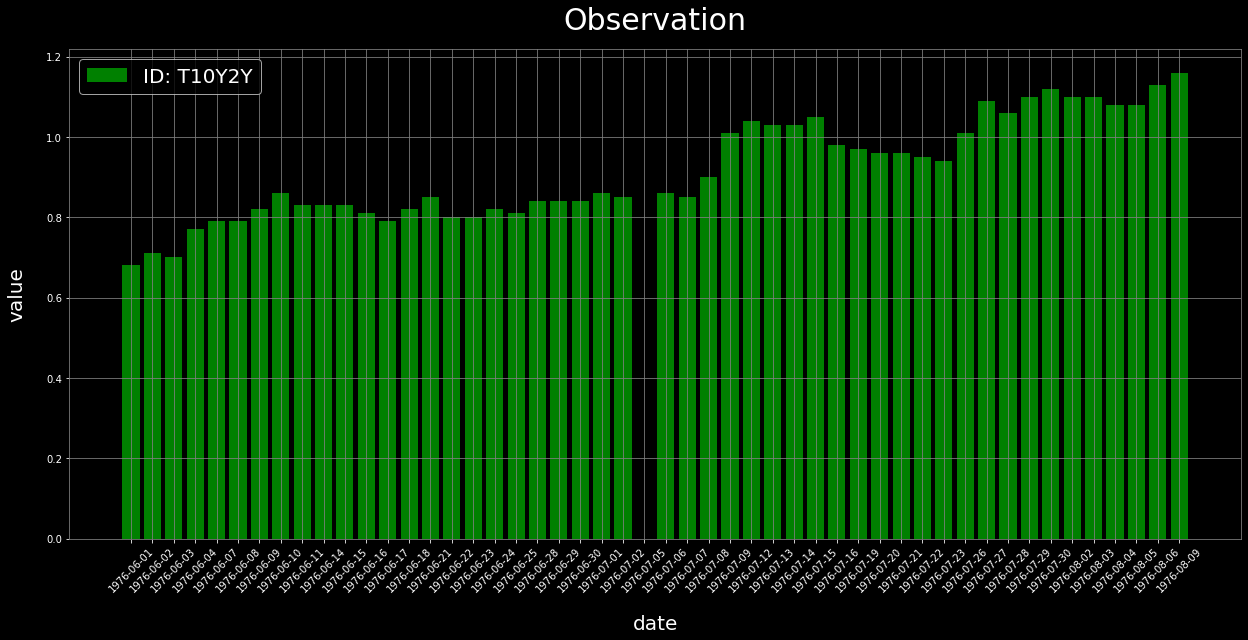

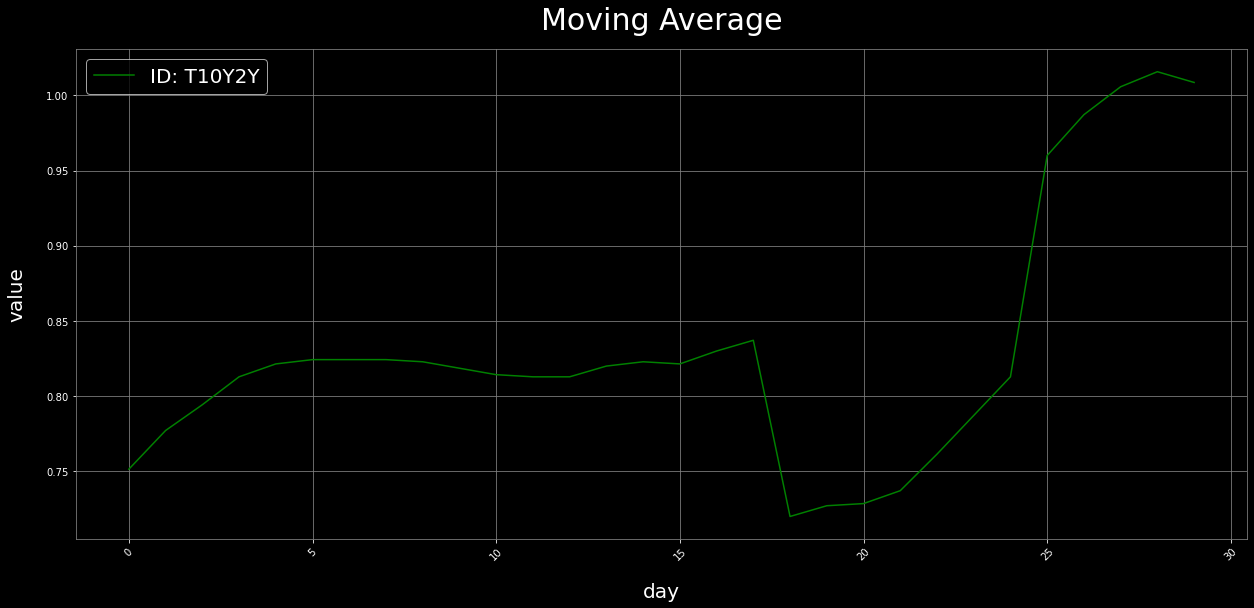

In [82]:
#Graficare l’andamento di una osservabile (se possibile)

grid_color = "grey"
label_color = "white"
plot_color="green"
title_fontsize = 30
axes_fontsize = 20
text_pad = 20
context = {'axes.edgecolor':'grey',
           'axes.facecolor':'black',
           'font.family':'sans-serif', 
           'figure.facecolor':'black', 
           'figure.edgecolor':'black',
           'xtick.color':'white', 
           'ytick.color':'white', 
           'savefig.transparent':'True'}

def convert_string_float(array_string):
    
    array_float = []
    
    for values in array_string:
    
        if values == ".": values = 0
    
        array_float.append(float(values))
    
    return array_float

def display_observation(id):
    
    pd = get_db(DB, "observations", id)
    x = pd['date'].tolist()
    y = pd['value'].tolist()
    y = convert_string_float(y)    
    
    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.bar(x[:50], y[:50], color=plot_color, label="ID: " + id)
        
        plt.title("Observation", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)

        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("date", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_observation.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
        
        plt.show()
        
#Graficare la media mobile (se possibile) di una osservabile a 𝑛 giorni (𝑛 parametro)
def moving_average(input_array, day):
    
    vett = convert_string_float(input_array)
    
    ret = []
    finestra = 0
    
    for i in range(day):
        finestra += vett[i]
        
    for i in range(day, len(vett)):
        ret.append(finestra / day)
        finestra = finestra + vett[i] - vett[i-day]
    
    return ret
    
def display_moving_average(id, day):
    
    pd = get_db(DB, "observations", id)
    x = pd['value'].tolist()    
    ma = moving_average(x, day)
    
    with plt.rc_context(context):
  
        plt.figure(figsize=(21,9))
        
        plt.plot(ma[:30], color=plot_color, label="ID: " + id)
        
        plt.title("Moving Average", color=label_color, pad=text_pad, fontsize=title_fontsize)
        plt.grid(color=grid_color)

        plt.ylabel("value", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xlabel("day", color=label_color, fontsize=axes_fontsize, labelpad=text_pad)
        plt.xticks(rotation=45)
        
        #mp.savefig('chart_moving_average.png')
        
        legend = plt.legend(fontsize=text_pad)
        plt.setp(legend.get_texts(), color=label_color)
        
        plt.show()
    
display_observation(ID_OBSERVATION)
display_moving_average(ID_OBSERVATION, 7)